In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms, utils
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
import copy
from IPython.display import display
from matplotlib import ticker
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score

In [ ]:
# Setting up gpu computing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Utilities functions

In [ ]:
# Freezing layers that we do not want to fit
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


# Model initialization for different pretrained networks
def initialize_model(model_name, num_classes, feature_extract,
                     use_pretrained=True):
    
    model_ft = None
    # input_size = 224 for all nets
    if model_name == "resnet":
        
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        

    elif model_name == "alexnet":
        
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "vgg":
        
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        

    elif model_name == "squeezenet":
        
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1),
                                           stride=(1,1))
        model_ft.num_classes = num_classes
        

    elif model_name == "densenet":
        
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft


# Create optimizer excluding frozen layers
def create_optimizer(model_ft, opt_type, feature_extract=False, lr=0.001,
                     momentum=0.99, weight_decay=0, betas=(0.9, 0.999)):
    optimizer_ft = None
    params_to_update = model_ft.parameters()
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)

    if opt_type == 'SGD':
        optimizer_ft = optim.SGD(params_to_update, lr=lr,
                            weight_decay=weight_decay)
        

    elif opt_type == 'Momentum':
        optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum,
                            weight_decay=weight_decay)
        
    
    elif opt_type == 'Nesterov':
        optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum,
                            weight_decay=weight_decay, nesterov=True)
        
        
    elif opt_type == 'Adam':
        optimizer_ft = optim.Adam(params_to_update, lr=lr,
                                  betas=betas, eps=1e-08,
                                  weight_decay=weight_decay)
        
    else:
        print("Invalid optimizer name, exiting...")
        exit()

    print()
    print('-' * 10)
    print(opt_type)
    print('-' * 10)
    return optimizer_ft


# Prepare model before training
def prepare_model(model_name, device, opt_type, **kwargs):
    
    if model_name == "simplenet":
        model = SimpleNet()
    elif model_name == 'simplenet_xavier':
        model = SimpleNet_Xavier()
    elif model_name == 'simplenet_kaiming':
        model = SimpleNet_Kaiming()
    else:
        model = initialize_model(model_name, 10,
                                        feature_extract=False,
                                  use_pretrained=True)
        
    model = model.to(device)
    optimizer = create_optimizer(model, opt_type, **kwargs)
    criterion = nn.CrossEntropyLoss()
    print('-' * 10)
    print(model_name)
    print('-' * 10)
    print()

    return model, criterion, optimizer
    


# Calculating accuracy
def compute_accuracy(net, testloader, device):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Accuracy on test images:{100 * correct / total}")



# From https://stackoverflow.com/questions/62265351/measuring-f1-score-
# for-multiclass-classification-natively-in-pytorch
class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor):
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int):
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels,
                                                   label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive,
                              torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(
                                    true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1),
                         torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor):
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions,
                                                          labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score



# Calclulate ROC AUC, stratified batches needed
def roc_auc_compute_fn(y_preds: torch.Tensor, y_targets: torch.Tensor):

    y_true = y_targets.detach().cpu().numpy()
    y_pred = y_preds.detach().cpu().numpy()
    # Normalizing for probabilities to sum to 1
    sum_of_rows = y_pred.sum(axis=1)
    y_pred = y_pred / sum_of_rows[:, np.newaxis]
    return roc_auc_score(y_true, y_pred, multi_class='ovr')



# Based on modified https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given
     patience.
    """
    def __init__(self, patience=3, delta=0.04):
        """
        Args:
            patience (int): How long to wait after last time validation loss
                            improved.
                            Default: 3
            delta (float): Minimum change in the monitored quantity to qualify
                           as an improvement.
                            Default: 0.04           
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0  



# Function for training model from scrath, finetuning and feature extraction
def train_model(model, criterion, optimizer, num_epochs, dataloaders, patience,
                delta, sched=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    val_f1_history = []
    val_auc_history = []

    train_acc_history = []
    train_loss_history = []
    train_f1_history = []
    train_auc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    f1_metric = F1Score('macro')
    # Scheduler for optimizing learning rate
    if sched:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max=num_epochs)
        
    # Initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, delta=delta)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0.0
            #running_auc = 0.0

            # Iterate over data
            for i, data in enumerate(dataloaders[phase], 1):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if sched:
                            scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_f1 += f1_metric(preds, labels.data) * inputs.size(0)
                #running_auc += roc_auc_compute_fn(outputs, labels.data)


            # print loss and acc each epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() \
             / len(dataloaders[phase].dataset)
            epoch_f1 = running_f1 / len(dataloaders[phase].dataset)
            #epoch_auc = running_auc / len(dataloaders[phase].dataset)
            print()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                time_to_best_acc = time.time() - since
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_f1_history.append(epoch_f1)
                #val_auc_history.append(epoch_auc)
                # early stopping based on loss
                early_stopping(epoch_loss)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                train_f1_history.append(epoch_f1)
                #train_auc_history.append(epoch_auc)

        # early stopping
        if early_stopping.early_stop:
            print()
            print("@@@@ Early stopping @@@@")
            print()
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed //
                                                        60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # create dicts with scores
    val_dict = {"acc": val_acc_history, "loss": val_loss_history,
                "f1": val_f1_history, "auc": val_auc_history}

    train_dict = {"acc": train_acc_history, "loss": train_loss_history,
                "f1": train_f1_history, "auc": train_auc_history}

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_dict, train_dict, time_to_best_acc


# Plot history of fitting
def plot_hist(hists, names, model_name, phase, metric, num_epochs):
    
    if torch.is_tensor(hists[0][0]):
        hists = [[h.cpu().numpy() for h in hist] for hist in hists]
    plt.title(f"Training process on {phase} dataset")
    plt.xlabel("Training epochs")
    plt.ylabel(f"Value of {metric}")
    for hist, name in zip(hists, names):
        plt.plot(range(1,len(hist)+1),hist,label=name)

    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter(
                "{x:.3f}"))
    plt.show()



# Plot multiple plots
def plot_hists(hists_dictionary, methods, model_name, phases, num_epochs,
               metrics, size=(8,8)):
    for metric in metrics:
        print()
        print(metric)
        print()
        for i, phase in enumerate(phases):
            hist = hists_dictionary[phase]
            metric_values = [h[metric] for h in hist]
            plt.subplots(figsize=size)
            plt.subplot(211 + i)
            plot_hist(metric_values, methods, model_name, phase, metric,
                      num_epochs)
            



# Tables of results
def table_results(val_dicts, train_dicts, times, names, metrics, model_name, 
                  lrs):

    rows = {}
    colnames = ['time_to_best_acc', 'lr']
    for i, name in enumerate(names):
        rows[name] = [times[i], lrs[i]]
        val_dict = val_dicts[i]
        train_dict = train_dicts[i]
        
        for metric in metrics:
            hist_val = val_dict[metric]
            hist_train = train_dict[metric]

            if torch.is_tensor(hist_val[0]):
                hist_val = [hist.cpu().numpy() for hist in hist_val]
                hist_train = [hist.cpu().numpy() for hist in hist_train]

            if metric == 'loss':
                best_val = np.min(hist_val)
                best_train = np.min(hist_train)
            else:
                best_val = np.max(hist_val)
                best_train = np.max(hist_train)

            rows[name].append(best_val)
            rows[name].append(best_train)
            
    for metric in metrics:
        colnames.append(f"best_train_{metric}")
        colnames.append(f"best_val_{metric}")
           
    table = pd.DataFrame.from_dict(rows, orient='index',
                       columns=colnames)
    #table = table.style.set_caption(f"Training results for {model_name}")
    return table




# Calculate average of returned dicts
def dicts_average(dicts):
    metrics = dicts[0].keys()
    final_dict = dict.fromkeys(metrics)
    for m in metrics:
        temp = 0
        for d in dicts:
            if type(d[m]) == list:
                d[m] = np.array(d[m])
            temp += d[m]
        temp = temp / len(dicts)
        final_dict[m] = temp
    return final_dict

Cosine scheduler: https://arxiv.org/abs/1608.03983 \
ReduceLROnPlateau: https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/ \
Super-Convergence: https://arxiv.org/abs/1708.07120

# Dataset

In [ ]:
# To tensors
transform_train = transforms.Compose([
    # Data augmentation                              
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Settings
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders_dict = {'train':trainloader, 'val':testloader}

# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


# Simple network

In [ ]:
# Deffining our simple network and its architecure 
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Experiments

Maybe we should establish the optimal learning rate and parameters for each method first. But it may also depend on the selected model. (Below - fact that validation acc is better at the start is probably due that validation dataset has not any augmentation.)

In [ ]:
# learning parameters
num_epochs = 10
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# methodology parameters
methods = ['SGD', 'Momentum', 'Nesterov', 'Adam']
phases = ['train', 'val']
metrics = ['acc', 'loss', 'f1'] #'auc'

# early stopping parameters
patience = 4
delta = 0.01

# display parameters
pd.options.display.float_format = "{:,.4f}".format

batch size: https://www.sciencedirect.com/science/article/pii/S2405959519303455 \
learning rates: http://proceedings.mlr.press/v28/sutskever13.html \
momentum: http://proceedings.mlr.press/v28/sutskever13.html, https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/ \
adam: https://arxiv.org/pdf/1905.11286.pdf

With AUC there is a problem with not stratified batches. We could stratified them in dataloaders, but I don't think that it is a good idea.

## Simple net

In [ ]:
model_name = 'simplenet'
hists_sn = {'train': [], 'val': []}
times_sn = []
best_lrs_sn = []

for method in methods:
    lowest_loss = np.Inf
    for lr in lrs:
        print()
        print(f'Learning rate = {lr}')
        print()
        net = prepare_model(model_name, device, method, lr=lr)
        _, v_dict, t_dict, time_i = train_model(*net,
                                                num_epochs=num_epochs,
                                                dataloaders=dataloaders_dict,
                                                patience=patience, delta=delta)
        curr_loss = np.min(v_dict['loss'])
        if curr_loss < lowest_loss:
            lowest_loss = curr_loss
            v_dict_best = v_dict
            t_dict_best = t_dict
            time_i_best = time_i
            best_lr = lr

    hists_sn['train'].append(t_dict_best)
    hists_sn['val'].append(v_dict_best)
    times_sn.append(time_i_best)
    best_lrs_sn.append(best_lr)


Learning rate = 0.1


----------
SGD
----------
----------
simplenet
----------

Epoch 1/10
----------

train Loss: 1.8391 Acc: 0.3233

val Loss: 1.6759 Acc: 0.3964

Epoch 2/10
----------

train Loss: 1.5536 Acc: 0.4357

val Loss: 1.5199 Acc: 0.4489

Epoch 3/10
----------

train Loss: 1.4375 Acc: 0.4813

val Loss: 1.3743 Acc: 0.5076

Epoch 4/10
----------

train Loss: 1.3635 Acc: 0.5114

val Loss: 1.4537 Acc: 0.4948

Epoch 5/10
----------

train Loss: 1.3057 Acc: 0.5342

val Loss: 1.3568 Acc: 0.5137

Epoch 6/10
----------

train Loss: 1.2635 Acc: 0.5504

val Loss: 1.1911 Acc: 0.5690

Epoch 7/10
----------

train Loss: 1.2339 Acc: 0.5630

val Loss: 1.6255 Acc: 0.4727

Epoch 8/10
----------

train Loss: 1.2164 Acc: 0.5699

val Loss: 1.2191 Acc: 0.5781

Epoch 9/10
----------

train Loss: 1.1897 Acc: 0.5792

val Loss: 1.1066 Acc: 0.6106

Epoch 10/10
----------

train Loss: 1.1680 Acc: 0.5903

val Loss: 1.0901 Acc: 0.6147

Training complete in 1m 35s
Best val Acc: 0.614700

Learning rate =


acc



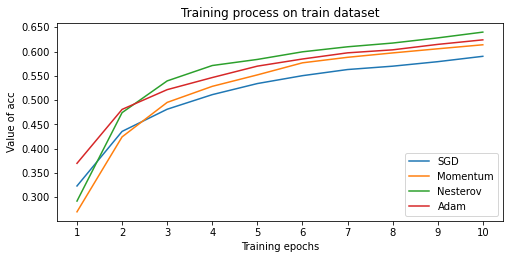

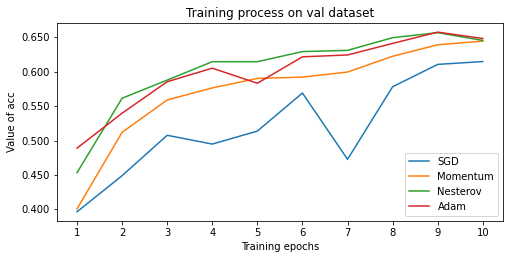


loss



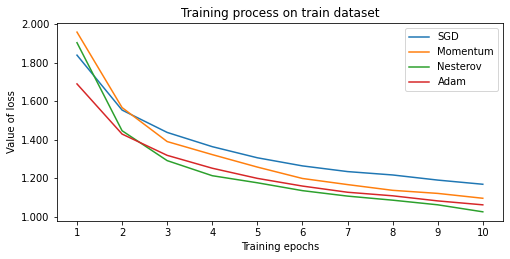

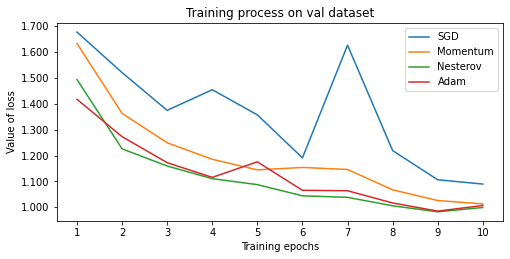


f1



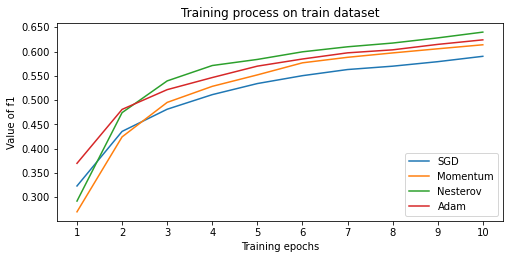

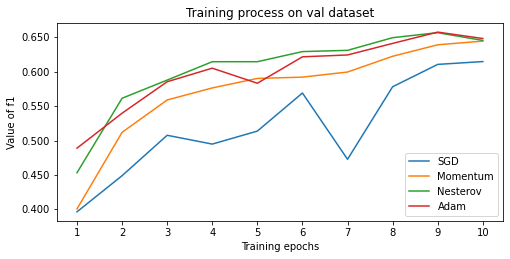

In [ ]:
plot_hists(hists_sn, methods, model_name, phases, num_epochs, metrics)       

In [ ]:
table_sn = table_results(hists_sn['train'], hists_sn['val'], times_sn, methods,
                         metrics, model_name, best_lrs_sn)
display(table_sn)

,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
SGD,94.8257,0.1000,0.5903,0.6147,1.1680,1.0901,0.5903,0.6147
Momentum,95.3322,0.0010,0.6140,0.6444,1.0952,1.0136,0.6140,0.6444
Nesterov,85.4228,0.0010,0.6401,0.6567,1.0248,0.9831,0.6401,0.6567
Adam,87.2005,0.0010,0.6241,0.6575,1.0611,0.9858,0.6241,0.6575


## Resnet

In [ ]:
model_name = 'resnet'
hists_rn = {'train': [], 'val': []}
times_rn = []
best_lrs_rn = []

for method in methods:
    lowest_loss = np.Inf
    for lr in lrs:
        print()
        print(f'Learning rate = {lr}')
        print()
        net = prepare_model(model_name, device, method, lr=lr)
        _, v_dict, t_dict, time_i = train_model(*net,
                                                num_epochs=num_epochs,
                                                dataloaders=dataloaders_dict,
                                                patience=patience, delta=delta)
        curr_loss = np.min(v_dict['loss'])
        if curr_loss < lowest_loss:
            lowest_loss = curr_loss
            v_dict_best = v_dict
            t_dict_best = t_dict
            time_i_best = time_i
            best_lr = lr

    hists_rn['train'].append(t_dict_best)
    hists_rn['val'].append(v_dict_best)
    times_rn.append(time_i_best)
    best_lrs_rn.append(best_lr)


Learning rate = 0.1


----------
SGD
----------
----------
resnet
----------

Epoch 1/10
----------

train Loss: 1.5852 Acc: 0.4855

val Loss: 2.7444 Acc: 0.3454

Epoch 2/10
----------

train Loss: 0.9496 Acc: 0.6755

val Loss: 1.1467 Acc: 0.6269

Epoch 3/10
----------

train Loss: 0.8499 Acc: 0.7090

val Loss: 1.2537 Acc: 0.6116

Epoch 4/10
----------

train Loss: 0.7611 Acc: 0.7378

val Loss: 0.8008 Acc: 0.7205

Epoch 5/10
----------

train Loss: 0.7148 Acc: 0.7538

val Loss: 1.5778 Acc: 0.5508

Epoch 6/10
----------

train Loss: 0.6281 Acc: 0.7832

val Loss: 0.9230 Acc: 0.7262

Epoch 7/10
----------

train Loss: 0.5824 Acc: 0.7990

val Loss: 0.7638 Acc: 0.7616

Epoch 8/10
----------

train Loss: 0.5468 Acc: 0.8121

val Loss: 0.6964 Acc: 0.7727

Epoch 9/10
----------

train Loss: 0.5389 Acc: 0.8145

val Loss: 1.4830 Acc: 0.5903

Epoch 10/10
----------

train Loss: 0.5220 Acc: 0.8190

val Loss: 0.7837 Acc: 0.7581

Training complete in 2m 45s
Best val Acc: 0.772700

Learning rate = 0.


acc



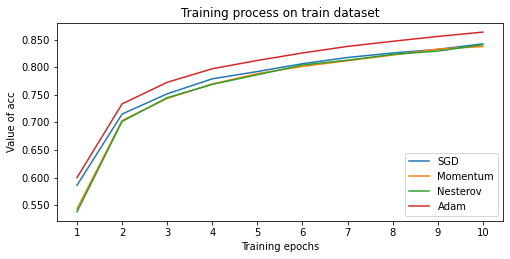

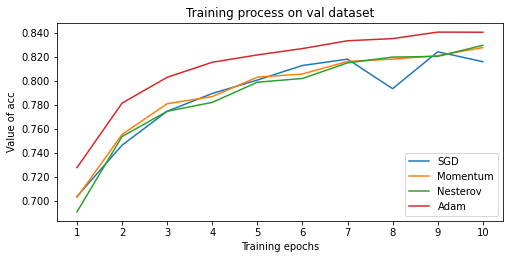


loss



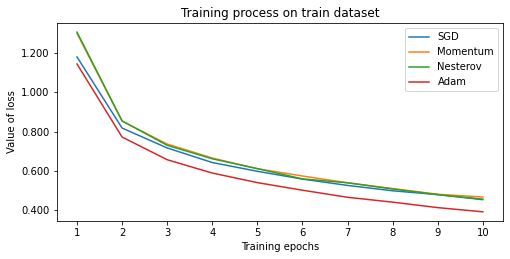

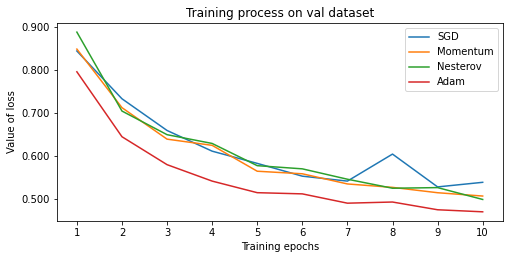


f1



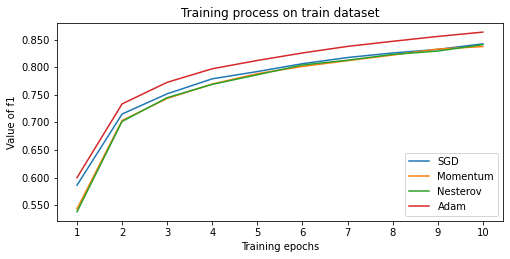

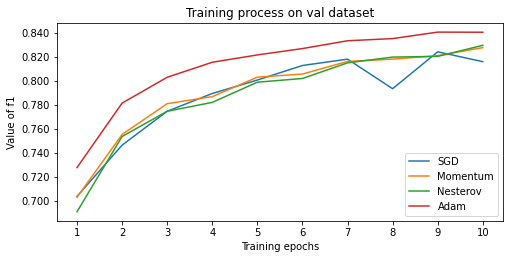

In [ ]:
plot_hists(hists_rn, methods, model_name, phases, num_epochs, metrics) 

In [ ]:
table_rn = table_results(hists_rn['train'], hists_rn['val'], times_rn, methods,
                         metrics, model_name, best_lrs_rn)
display(table_rn)

,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
SGD,147.2486,0.0100,0.8423,0.8242,0.4524,0.5285,0.8423,0.8242
Momentum,166.9955,0.0001,0.8374,0.8277,0.4659,0.5072,0.8374,0.8277
Nesterov,166.4146,0.0001,0.8408,0.8296,0.4548,0.4993,0.8408,0.8296
Adam,157.7286,0.0001,0.8636,0.8406,0.3903,0.4706,0.8636,0.8406


# VGG

In [ ]:
model_name = 'vgg'
hists_vgg = {'train': [], 'val': []}
times_vgg = []
best_lrs_vgg = []

for method in methods:
    lowest_loss = np.Inf
    for lr in lrs:
        print()
        print(f'Learning rate = {lr}')
        print()
        net = prepare_model(model_name, device, method, lr=lr)
        _, v_dict, t_dict, time_i = train_model(*net,
                                                num_epochs=num_epochs,
                                                dataloaders=dataloaders_dict,
                                                patience=patience, delta=delta)
        curr_loss = np.min(v_dict['loss'])
        if curr_loss < lowest_loss:
            lowest_loss = curr_loss
            v_dict_best = v_dict
            t_dict_best = t_dict
            time_i_best = time_i
            best_lr = lr

    hists_vgg['train'].append(t_dict_best)
    hists_vgg['val'].append(v_dict_best)
    times_vgg.append(time_i_best)
    best_lrs_vgg.append(best_lr)


acc



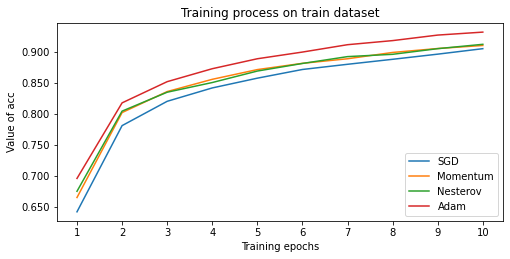

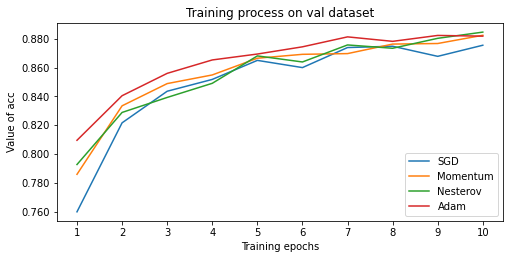


loss



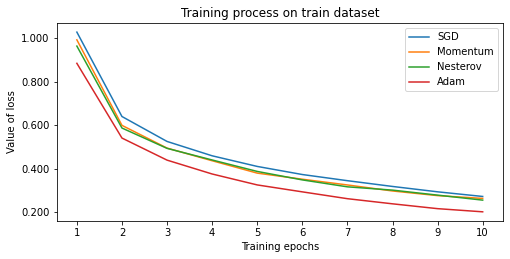

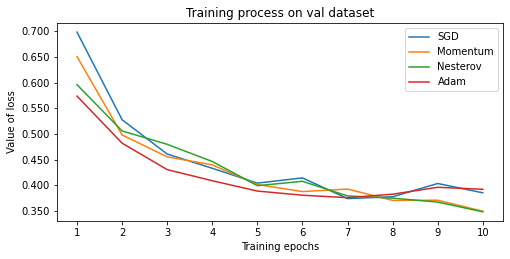


f1



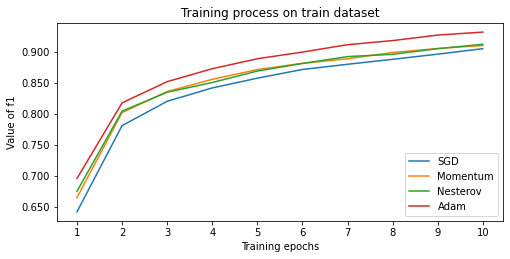

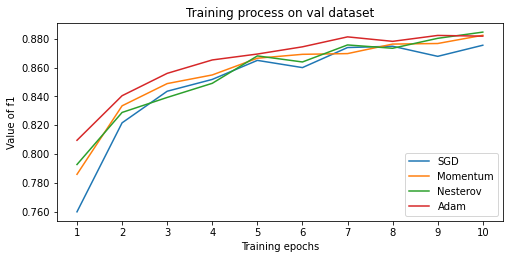

In [ ]:
plot_hists(hists_vgg, methods, model_name, phases, num_epochs, metrics) 

In [ ]:
table_vgg = table_results(hists_vgg['train'], hists_vgg['val'], times_vgg,
                         methods, metrics, model_name, best_lrs_vgg)
display(table_vgg)

,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
SGD,255.6491,0.0100,0.9057,0.8755,0.2727,0.3741,0.9057,0.8755
Momentum,293.4846,0.0010,0.9109,0.8824,0.2638,0.3495,0.9109,0.8824
Nesterov,315.9222,0.0010,0.9128,0.8846,0.2558,0.3484,0.9128,0.8846
Adam,346.7889,0.0001,0.9325,0.8823,0.2021,0.3759,0.9325,0.8823



From the graphs above, we can see that the Nesterov Momentum has achieved on average slightly better results than others on SimpleNet. On the pretrained networks Adam method was the best.

## Robustness

Methodology: https://ieeexplore.ieee.org/document/9366477 
Or maybe label noise? https://arxiv.org/pdf/1705.10694.pdf or https://arxiv.org/pdf/1906.03367.pdf

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean,
                                                                      self.std)

In [ ]:
# To tensors
transform_train = transforms.Compose([
    # Data augmentation                              
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    AddGaussianNoise(0., 1.) # Noise
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders_dict = {'train':trainloader, 'val':testloader}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# learning parameters
num_epochs = 10
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# methodology parameters
methods = ['SGD', 'Momentum', 'Nesterov', 'Adam']
phases = ['train', 'val']
metrics = ['acc', 'loss', 'f1'] #'auc'

# early stopping parameters
patience = 4
delta = 0.01

# display parameters
pd.options.display.float_format = "{:,.4f}".format

I have used f1-micro which in this claffication task is equal to accuracy. I have already changed f1-micro to f1-macro in code, but it needs restart all of chunks.

Becouse vgg and resnet had similiar results now we use only smaller pretrained 
network

In [ ]:
models_names = ['simplenet', 'resnet']

In [ ]:
hists_val = {'simplenet': {'train': [], 'val': []},
             'resnet': {'train': [], 'val': []}}
times = {'simplenet': [], 'resnet': []}
best_lrs = {'simplenet': [], 'resnet': []}

for model_name in models_names:
    for method in methods:
        lowest_loss = np.Inf
        for lr in lrs:
            print()
            print(f'Learning rate = {lr}')
            print()

            net = prepare_model(model_name, device, method, lr=lr)
            _, v_dict, t_dict, time_i = train_model(*net,
                                                    num_epochs=num_epochs,
                                                    dataloaders=dataloaders_dict,
                                                    patience=patience,
                                                    delta=delta)
            
            curr_loss = np.min(v_dict['loss'])
            if curr_loss < lowest_loss:
                lowest_loss = curr_loss
                v_dict_best = v_dict
                t_dict_best = t_dict
                time_i_best = time_i
                best_lr = lr
            
        hists_val[model_name]['train'].append(t_dict_best)
        hists_val[model_name]['val'].append(v_dict_best)
        times[model_name].append(time_i_best)
        best_lrs[model_name].append(best_lr)


Learning rate = 0.1


----------
SGD
----------
----------
simplenet
----------

Epoch 1/10
----------

train Loss: 1.8893 Acc: 0.3041

val Loss: 1.6703 Acc: 0.3952

Epoch 2/10
----------

train Loss: 1.6451 Acc: 0.3994

val Loss: 1.6637 Acc: 0.4064

Epoch 3/10
----------

train Loss: 1.5589 Acc: 0.4359

val Loss: 1.5223 Acc: 0.4441

Epoch 4/10
----------

train Loss: 1.5059 Acc: 0.4557

val Loss: 1.8313 Acc: 0.4117

Epoch 5/10
----------

train Loss: 1.4646 Acc: 0.4715

val Loss: 1.5343 Acc: 0.4539

Epoch 6/10
----------

train Loss: 1.4349 Acc: 0.4838

val Loss: 1.3978 Acc: 0.4921

Epoch 7/10
----------

train Loss: 1.4132 Acc: 0.4917

val Loss: 1.2972 Acc: 0.5395

Epoch 8/10
----------

train Loss: 1.3948 Acc: 0.4977

val Loss: 1.3106 Acc: 0.5266

Epoch 9/10
----------

train Loss: 1.3781 Acc: 0.5047

val Loss: 1.3812 Acc: 0.5181

Epoch 10/10
----------

train Loss: 1.3565 Acc: 0.5147

val Loss: 1.3445 Acc: 0.5230

Training complete in 2m 14s
Best val Acc: 0.539500

Learning rate =

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth




----------
SGD
----------
----------
resnet
----------

Epoch 1/10
----------

train Loss: 1.9462 Acc: 0.3701

val Loss: 21.9524 Acc: 0.0918

Epoch 2/10
----------

train Loss: 1.5056 Acc: 0.4659

val Loss: 2.5713 Acc: 0.3336

Epoch 3/10
----------

train Loss: 1.2740 Acc: 0.5503

val Loss: 2.5883 Acc: 0.4202

Epoch 4/10
----------

train Loss: 1.1668 Acc: 0.5862

val Loss: 2.2065 Acc: 0.3585

Epoch 5/10
----------

train Loss: 1.0986 Acc: 0.6129

val Loss: 2.0056 Acc: 0.4173

Epoch 6/10
----------

train Loss: 1.0570 Acc: 0.6273

val Loss: 10.6201 Acc: 0.1234

Epoch 7/10
----------

train Loss: 1.1064 Acc: 0.6116

val Loss: 1.6069 Acc: 0.4721

Epoch 8/10
----------

train Loss: 0.9739 Acc: 0.6590

val Loss: 1.5350 Acc: 0.5053

Epoch 9/10
----------

train Loss: 0.9346 Acc: 0.6720

val Loss: 1.5259 Acc: 0.5585

Epoch 10/10
----------

train Loss: 0.8996 Acc: 0.6845

val Loss: 2.2808 Acc: 0.3978

Training complete in 2m 42s
Best val Acc: 0.558500

Learning rate = 0.01


----------
SGD


simplenet


loss



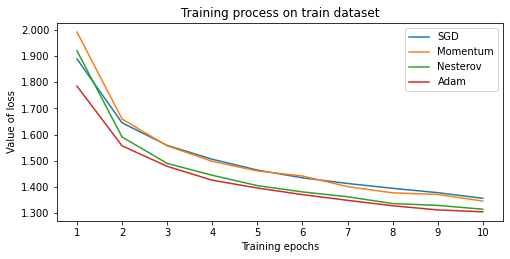

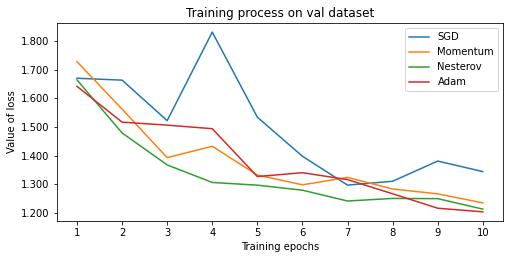


resnet


loss



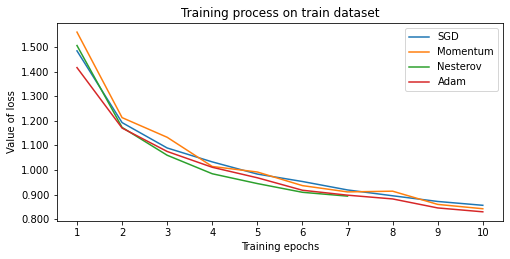

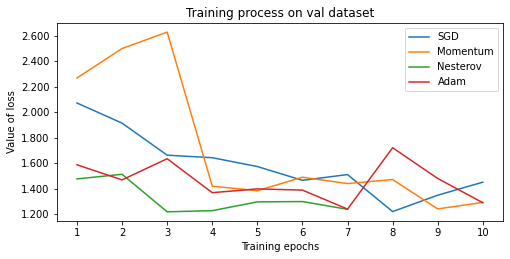

In [ ]:
for model_name in models_names:
    print()
    print(model_name)
    print()
    plot_hists(hists_val[model_name], methods, model_name, phases,
               num_epochs, ['loss']) 

In [ ]:
for model_name in models_names:
    table = table_results(hists_val[model_name]['train'],
                              hists_val[model_name]['val'], times[model_name],
                         methods, metrics, model_name, best_lrs[model_name])
    display(table)


,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
SGD,92.8644,0.1000,0.5147,0.5395,1.3565,1.2972,0.5147,0.5395
Momentum,133.5362,0.0010,0.5199,0.5667,1.3460,1.2353,0.5199,0.5667
Nesterov,133.4073,0.0010,0.5317,0.5690,1.3148,1.2134,0.5317,0.5690
Adam,134.7243,0.0010,0.5299,0.5805,1.3049,1.2040,0.5299,0.5805


,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
SGD,130.0273,0.0100,0.6991,0.5849,0.8562,1.2200,0.6991,0.5849
Momentum,151.5151,0.0010,0.7062,0.5878,0.8422,1.2410,0.7062,0.5878
Nesterov,67.6915,0.0010,0.6883,0.5866,0.8934,1.2183,0.6883,0.5866
Adam,162.8683,0.0010,0.7109,0.5834,0.8297,1.2397,0.7109,0.5834


# Weights initialization

Methodology: We will focus on initialization of fully connected layers and use learning rates obtained from previous experiments. For each initialization method we will average final results from 3 runs. We will use pytorch deafult initialization, Kaiming initialization and normal Xavier initialization method.

## Methods

### Pytorch default

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Kaiming

In [ ]:
class SimpleNet_Kaiming(nn.Module):
    def __init__(self):
        super(SimpleNet_Kaiming, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20 * 5 * 5, 100)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(100, 84)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Xavier

In [ ]:
class SimpleNet_Xavier(nn.Module):
    def __init__(self):
        super(SimpleNet_Xavier, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20 * 5 * 5, 100)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(100, 84)
        nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Comparison for each optimalization algorithm

In [ ]:
# To tensors
transform_train = transforms.Compose([
    # Data augmentation                              
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Settings
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders_dict = {'train':trainloader, 'val':testloader}

# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

In [ ]:
# learning parameters
num_epochs = 5

# methodology parameters
methods = ['SGD', 'Momentum', 'Nesterov', 'Adam']
phases = ['train', 'val']
metrics = ['acc', 'loss', 'f1'] #'auc'

# early stopping parameters
patience = 20
delta = 0.01

# display parameters
pd.options.display.float_format = "{:,.4f}".format

In [ ]:
inits = ['Default', 'Kaiming', 'Xavier']
nets = ['simplenet', 'simplenet_kaiming', 'simplenet_xavier']
runs = 3

In [ ]:
results = {'SGD': {'train': [], 'val': []},
             'Momentum': {'train': [], 'val': []},
             'Nesterov': {'train': [], 'val': []},
             'Adam': {'train': [], 'val': []}}
times_inits = {'SGD': [], 'Momentum': [], 'Nesterov': [], 'Adam': []}
lrs_inits = {'SGD': [], 'Momentum': [], 'Nesterov': [], 'Adam': []}

for method in methods:
    if method == 'SGD':
        lr = 0.1
    else:
        lr = 0.001
    for i, init in enumerate(inits):
        v_dicts = []
        t_dicts = []
        time_is = 0
        for j in range(runs):
            print(f'{init} attempt {j}')
            net = prepare_model(nets[i], device, method, lr=lr)
            _, v_dict, t_dict, time_i = train_model(*net,
                                                    num_epochs=num_epochs,
                                                    dataloaders=dataloaders_dict,
                                                    patience=patience,
                                                    delta=delta)
            v_dicts.append(v_dict)
            t_dicts.append(t_dict)
            time_is += time_i

        v_dict = dicts_average(v_dicts)
        t_dict = dicts_average(t_dicts)
        time_i = time_is / runs
            
        results[method]['train'].append(t_dict)
        results[method]['val'].append(v_dict)
        times_inits[method].append(time_i)
        lrs_inits[method].append(lr)

Default attempt 0

----------
SGD
----------
----------
simplenet
----------

Epoch 1/5
----------

train Loss: 1.8583 Acc: 0.3144

val Loss: 1.6039 Acc: 0.4182

Epoch 2/5
----------

train Loss: 1.5577 Acc: 0.4332

val Loss: 1.4609 Acc: 0.4821

Epoch 3/5
----------

train Loss: 1.4233 Acc: 0.4865

val Loss: 1.4305 Acc: 0.4928

Epoch 4/5
----------

train Loss: 1.3403 Acc: 0.5205

val Loss: 1.2023 Acc: 0.5735

Epoch 5/5
----------

train Loss: 1.2832 Acc: 0.5425

val Loss: 1.3434 Acc: 0.5122

Training complete in 1m 0s
Best val Acc: 0.573500
Default attempt 1

----------
SGD
----------
----------
simplenet
----------

Epoch 1/5
----------

train Loss: 1.8461 Acc: 0.3208

val Loss: 1.7368 Acc: 0.3676

Epoch 2/5
----------

train Loss: 1.5577 Acc: 0.4324

val Loss: 1.4554 Acc: 0.4623

Epoch 3/5
----------

train Loss: 1.4319 Acc: 0.4857

val Loss: 1.3853 Acc: 0.5085

Epoch 4/5
----------

train Loss: 1.3530 Acc: 0.5155

val Loss: 1.3746 Acc: 0.5163

Epoch 5/5
----------

train Loss: 1.28


SGD


loss



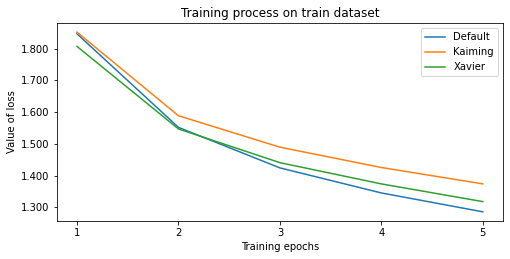

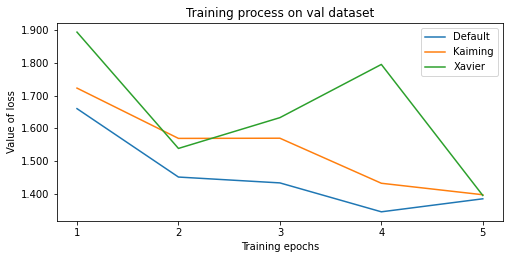


Momentum


loss



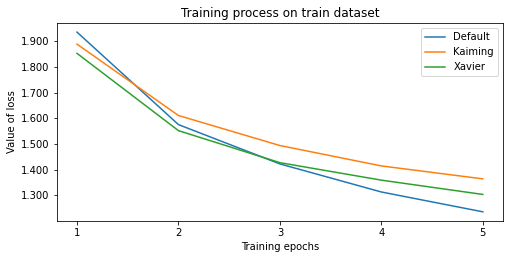

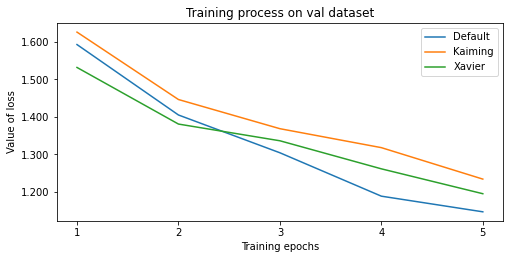


Nesterov


loss



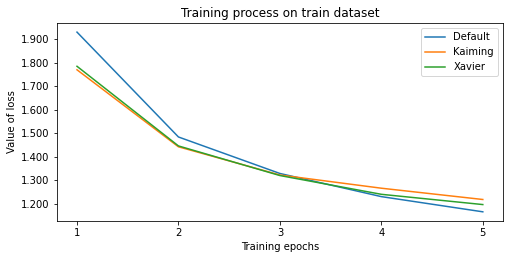

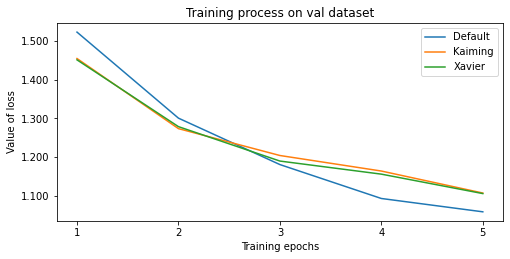


Adam


loss



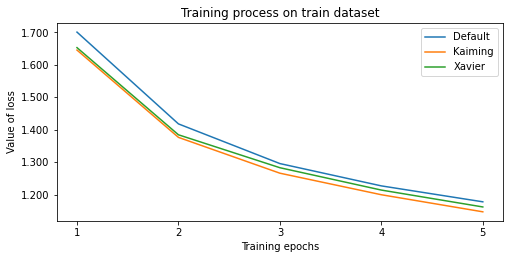

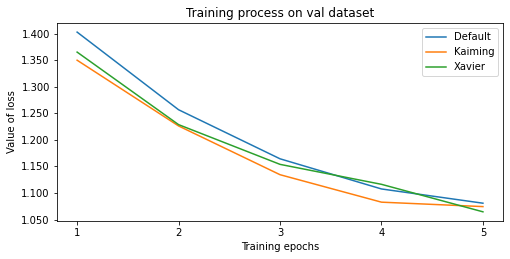

In [ ]:
for method in methods:
    print()
    print(method)
    print()
    plot_hists(results[method], inits, method, phases,
               num_epochs, ['loss']) 

In [ ]:
for method in methods:
    print(method)
    table = table_results(results[method]['train'],
                              results[method]['val'], times_inits[method],
                         inits, metrics, 'simplenet', lrs_inits[method])
    display(table)

SGD


,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
Default,57.0809,0.1000,0.5408,0.5256,1.2858,1.3445,0.5408,0.5256
Kaiming,60.2614,0.1000,0.5065,0.5090,1.3738,1.3968,0.5065,0.5090
Xavier,60.2810,0.1000,0.5295,0.5082,1.3180,1.3946,0.5295,0.5082


Momentum


,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
Default,54.6895,0.0010,0.5609,0.5939,1.2352,1.1470,0.5609,0.5939
Kaiming,59.4657,0.0010,0.5132,0.5608,1.3637,1.2343,0.5132,0.5608
Xavier,59.4311,0.0010,0.5354,0.5753,1.3029,1.1953,0.5354,0.5753


Nesterov


,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
Default,59.3419,0.0010,0.5863,0.6286,1.1657,1.0578,0.5863,0.6286
Kaiming,54.8535,0.0010,0.5654,0.6028,1.2181,1.1066,0.5654,0.6028
Xavier,58.7954,0.0010,0.5753,0.6078,1.1965,1.1051,0.5753,0.6078


Adam


,time_to_best_acc,lr,best_train_acc,best_val_acc,best_train_loss,best_val_loss,best_train_f1,best_val_f1
Default,60.2940,0.0010,0.5796,0.6169,1.1781,1.0808,0.5796,0.6169
Kaiming,55.5761,0.0010,0.5924,0.6238,1.1472,1.0744,0.5924,0.6238
Xavier,60.5907,0.0010,0.5881,0.6274,1.1622,1.0646,0.5881,0.6274


From plots we can see that choice of initialization method has biggest impact on SGD learning method.